# Create initial conditions for the Pb model

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import pandas as pd
import pickle
import xarray as xr
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### Load files

In [3]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

GEOTRACES cruise CAA (and Canada Basin)

In [4]:
CAA = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
CAA_lons     = CAA['station lon'].dropna().astype('float').values[1:]
CAA_lats     = CAA['Station lat'].dropna().astype('float').values[1:]
CAA_names    = CAA['Station names'].dropna().astype('str')
CAA_Pb_short = [CAA['CB3'].dropna().astype('float').values, CAA['CB4'].dropna().astype('float').values, \
                CAA['LS2'].dropna().astype('float').values, CAA['BB1'].dropna().astype('float').values]
CAA_Pb       = [CAA['LS2'].dropna().astype('float').values, CAA['BB1'].dropna().astype('float').values, \
                CAA['BB2'].dropna().astype('float').values, CAA['BB3'].dropna().astype('float').values, \
                CAA['CAA1'].dropna().astype('float').values, CAA['CAA2'].dropna().astype('float').values, \
                CAA['CAA3'].dropna().astype('float').values, CAA['CAA4'].dropna().astype('float').values, \
                CAA['CAA5'].dropna().astype('float').values, CAA['CAA6'].dropna().astype('float').values, \
                CAA['CAA7'].dropna().astype('float').values, CAA['CAA8'].dropna().astype('float').values, \
                CAA['CAA9'].dropna().astype('float').values, CAA['CB1'].dropna().astype('float').values, \
                CAA['CB2'].dropna().astype('float').values, CAA['CB3'].dropna().astype('float').values, \
                CAA['CB4'].dropna().astype('float').values]

CAA_depth   = [CAA['Depth'][np.isfinite(CAA['LS2'])].astype('float'), CAA['Depth.1'][np.isfinite(CAA['BB1'])].astype('float'), \
               CAA['Depth.2'][np.isfinite(CAA['BB2'])].astype('float'), CAA['Depth.3'][np.isfinite(CAA['BB3'])].astype('float'), \
               CAA['Depth.4'][np.isfinite(CAA['CAA1'])].astype('float'), CAA['Depth.5'][np.isfinite(CAA['CAA2'])].astype('float'), \
               CAA['Depth.6'][np.isfinite(CAA['CAA3'])].astype('float'), CAA['Depth.7'][np.isfinite(CAA['CAA4'])].astype('float'), \
               CAA['Depth.8'][np.isfinite(CAA['CAA5'])].astype('float'), CAA['Depth.9'][np.isfinite(CAA['CAA6'])].astype('float'), \
               CAA['Depth.10'][np.isfinite(CAA['CAA7'])].astype('float'), CAA['Depth.11'][np.isfinite(CAA['CAA8'])].astype('float'), \
               CAA['Depth.12'][np.isfinite(CAA['CAA9'])].astype('float'), CAA['Depth.13'][np.isfinite(CAA['CB1'])].astype('float'), \
               CAA['Depth.14'][np.isfinite(CAA['CB2'])].astype('float'), CAA['Depth.15'][np.isfinite(CAA['CB3'])].astype('float'), \
               CAA['Depth.16'][np.isfinite(CAA['CB4'])].astype('float')]

GEOTRACES cruise North Atlantic

In [5]:
Pb = nc.Dataset('/ocean/brogalla/GEOTRACES/data/GEOTRACES_IDP2017_v2_Discrete_Sample_Data_5024209a_1.nc')

NA_lats   = np.array(Pb.variables['latitude'])
NA_lons   = np.array(Pb.variables['longitude'])-360
NA_depths = np.array(Pb.variables['var2'])
NA_time   = np.array(Pb.variables['date_time'])
Pb_NA     = np.array(Pb.variables['var5']) # in pmol/kg

masked_Pb_NA = np.ma.masked_where(np.logical_or(Pb_NA > 1e5, Pb_NA < -1e5), Pb_NA)

Pb from Arctic Ocean (US)

In [6]:
df = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb_rob_rember.csv', parse_dates=['DATE']).dropna()
AO_depths = np.array(df['CTDDEPTH'])
AO_lats   = np.array(df['LATITUDE'])
AO_lons   = np.array(df['LONGITUDE'])
AO_dPb    = np.array(df['Pb_(pMol)'])

Map of all cruise Pb station locations:

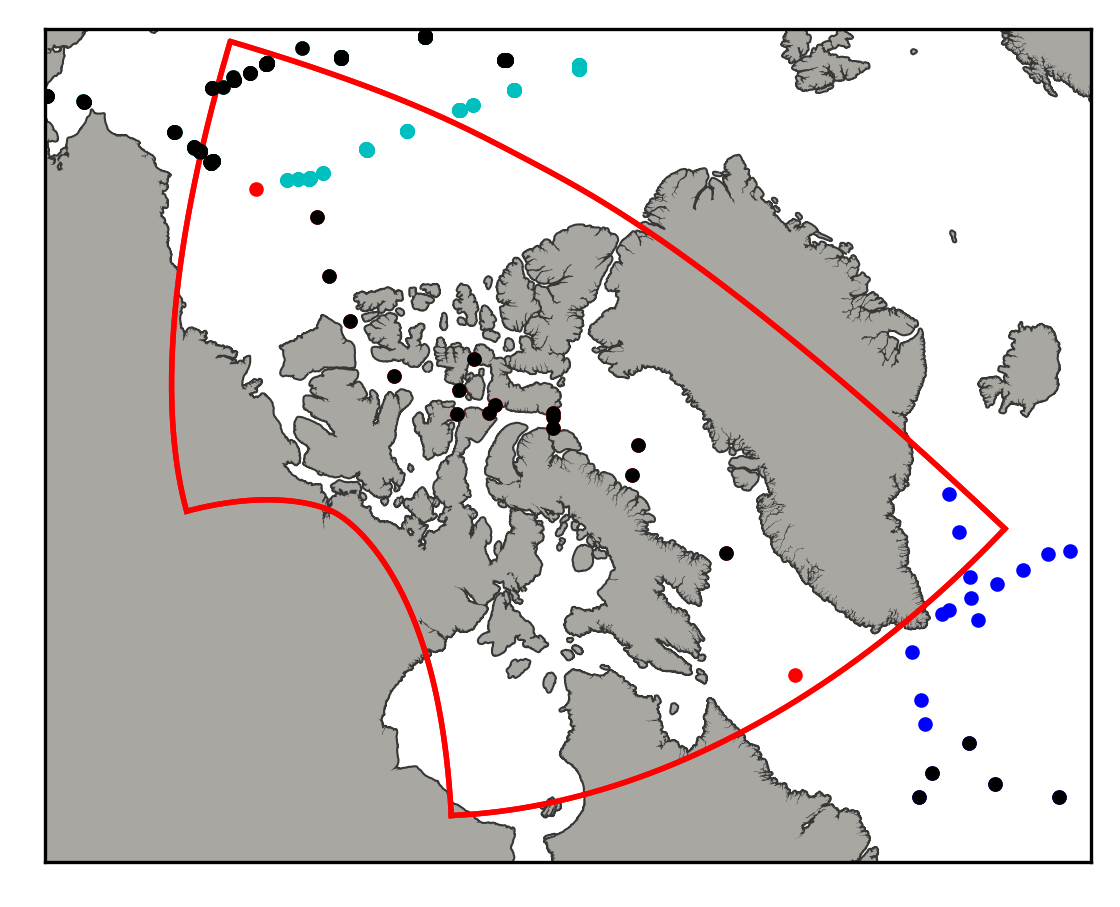

In [7]:
fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

x, y = proj(mesh_lon, mesh_lat)

# sub-domain:
proj.plot(x[imin:imax,jmax]   , y[imin:imax,jmax]   , 'r-', lw=1.3);
proj.plot(x[imin:imax,jmax].T , y[imin:imax,jmax].T , 'r-', lw=1.3);
proj.plot(x[imin:imax,jmin]   , y[imin:imax,jmin]   , 'r-', lw=1.3);
proj.plot(x[imin:imax,jmin].T , y[imin:imax,jmin].T , 'r-', lw=1.3);
proj.plot(x[imin,jmin:jmax]    , y[imin,jmin:jmax]    , 'r-', lw=1.3);
proj.plot(x[imin,jmin:jmax].T  , y[imin,jmin:jmax].T  , 'r-', lw=1.3);
proj.plot(x[imax,jmin:jmax]    , y[imax,jmin:jmax]    , 'r-', lw=1.3);
proj.plot(x[imax,jmin:jmax].T  , y[imax,jmin:jmax].T  , 'r-', lw=1.3);

# Canadian GEOTRACES station locations:
x_CAA, y_CAA = proj(CAA_lons, CAA_lats)
proj.plot(x_CAA, y_CAA, '.r', markersize=5)
proj.plot(x_CAA[1:16], y_CAA[1:16], '.k', markersize=5)

# North Atlantic GEOTRACES station locations:
x_NA, y_NA = proj(NA_lons, NA_lats)
proj.plot(x_NA, y_NA, '.b', markersize=5)
proj.plot(x_NA[NA_lats < 55], y_NA[NA_lats < 55], '.k', markersize=5)

# Arctic Ocean station locations:
x_AO, y_AO = proj(AO_lons, AO_lats)
proj.plot(x_AO, y_AO, '.c', markersize=5)
proj.plot(x_AO[0:144], y_AO[0:144], '.k', markersize=5)
proj.plot(x_AO[290:334], y_AO[290:334], '.k', markersize=5)

In [8]:
NA_lons_tot    = np.transpose(np.tile(NA_lons, (288,1)))
NA_lats_tot    = np.transpose(np.tile(NA_lats, (288,1)))

# Generalized function for kriging

Gaussian process regression. Kernel --- Rational quadratic

In [9]:
def krig(depth, CAA=False, \
         AO_lon=AO_lons, AO_lat=AO_lats, AO_depth=AO_depths, AO_dPb=AO_dPb, \
         NA_lons_tot=NA_lons_tot, NA_lats_tot=NA_lats_tot, NA_depths=NA_depths, NA_Pb=Pb_NA, \
         CAA_lons=CAA_lons, CAA_lats=CAA_lats, mesh_lon=mesh_lon, mesh_lat=mesh_lat):
    
    # input arguments:
    # - depth --- vector with two values indicating the range of depths that I want to create a field for
    # - CAA   --- whether or not to use CAA station data
    
    AOlons = AO_lon[(AO_depth < depth[1]) & (AO_depth > depth[0])]
    AOlats = AO_lat[(AO_depth < depth[1]) & (AO_depth > depth[0])]
    AOdPb  = AO_dPb[(AO_depth < depth[1]) & (AO_depth > depth[0])]    
    NAlons = NA_lons_tot[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    NAlats = NA_lats_tot[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    NAPb   = NA_Pb[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    
    CAAlons = np.empty([])
    CAAlats = np.empty([])
    CAAPb   = np.empty([])
    
    if CAA:
        # For CAA stations, create a list of dPb, lons, lats with depths that fall within the range below
        for stn in range(0, len(CAA_Pb)):
            dpb_caa = CAA_Pb[stn][(CAA_depth[stn] < depth[1]) & (CAA_depth[stn] > depth[0])]
            lon_stn = np.tile(CAA_lons[stn], len(dpb_caa))
            lat_stn = np.tile(CAA_lats[stn], len(dpb_caa))
            CAAPb     = np.append(dpb_caa, CAAPb)
            CAAlons   = np.append(lon_stn, CAAlons)
            CAAlats   = np.append(lat_stn, CAAlats)       
    else:      
        # For CAA stations, create a list of dPb, lons, lats with depths that fall within the range below
        stns = [0, 16]
        for stn in stns:
            dpb_caa = CAA_Pb[stn][(CAA_depth[stn] < depth[1]) & (CAA_depth[stn] > depth[0])]
            lon_stn = np.tile(CAA_lons[stn], len(dpb_caa))
            lat_stn = np.tile(CAA_lats[stn], len(dpb_caa))
            CAAPb     = np.append(dpb_caa, CAAPb)
            CAAlons   = np.append(lon_stn, CAAlons)
            CAAlats   = np.append(lat_stn, CAAlats)
        
    lons_combined = np.concatenate((CAAlons, AOlons, NAlons[NAPb > 0]))
    lats_combined = np.concatenate((CAAlats, AOlats, NAlats[NAPb > 0]))
    dPb_combined  = np.concatenate((CAAPb, AOdPb,  NAPb[NAPb > 0]))

    X = np.vstack((lons_combined, lats_combined)).transpose()
    y = dPb_combined
    h = .2  # step size in the mesh
    xx = mesh_lon[imin:imax,jmin:jmax]
    yy = mesh_lat[imin:imax,jmin:jmax]

    kernel            = sklearn.gaussian_process.kernels.RationalQuadratic()
    gpc_rbf_isotropic = GaussianProcessRegressor(kernel=kernel).fit(X, y)

    Z = gpc_rbf_isotropic.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape((xx.shape[0], xx.shape[1]))
        
    # Remove any negative values
    Z[Z < 0] = 0
    
    
    # output arguments:
    # - xx --- longitudes of mesh
    # - yy --- latitudes of mesh
    # - Z  --- kriged output field
    # - X  --- stations taken into account
    # - y  --- dPb concentrations of stations taken into account
    
    return xx, yy, Z, X, y

In [10]:
def plot_krig(xx, yy, Z, stns, dpb, vmax1):
    
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x_stns, y_stns = proj(stns[:,0], stns[:,1])
    proj.scatter(x_stns, y_stns, c=dpb, s=30, zorder=3, edgecolor='w', vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r)

    x_krig, y_krig = proj(xx, yy)
    bathy = mesh_bathy[0,imin:imax,jmin:jmax]
    Z_masked = np.ma.masked_where((bathy < 0.1), Z)
    print(Z_masked.min(), Z_masked.max(), Z_masked.mean())
    proj.pcolormesh(x_krig, y_krig, Z_masked, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r, zorder=2)

    # Colorbar:
    CS1 = proj.contourf(np.zeros((2,2)),np.zeros((2,2)), np.array([[0, vmax1],[0, vmax1]]), \
                        30, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r)
    CBar = plt.colorbar(CS1, fraction=0.04, ticks=np.arange(0, vmax1+5, 5))
    CBar.ax.tick_params(labelsize=7) 
    CBar.set_label('Dissolved Pb [pmol/kg]', fontsize=7)
    return

Using CAA stations:

In [11]:
xx_yes, yy_yes, Z_yes, stns_yes, dpb_yes = krig([0, 20], CAA=True)

1.1101713180541992 28.16458809375763 6.642364105039559


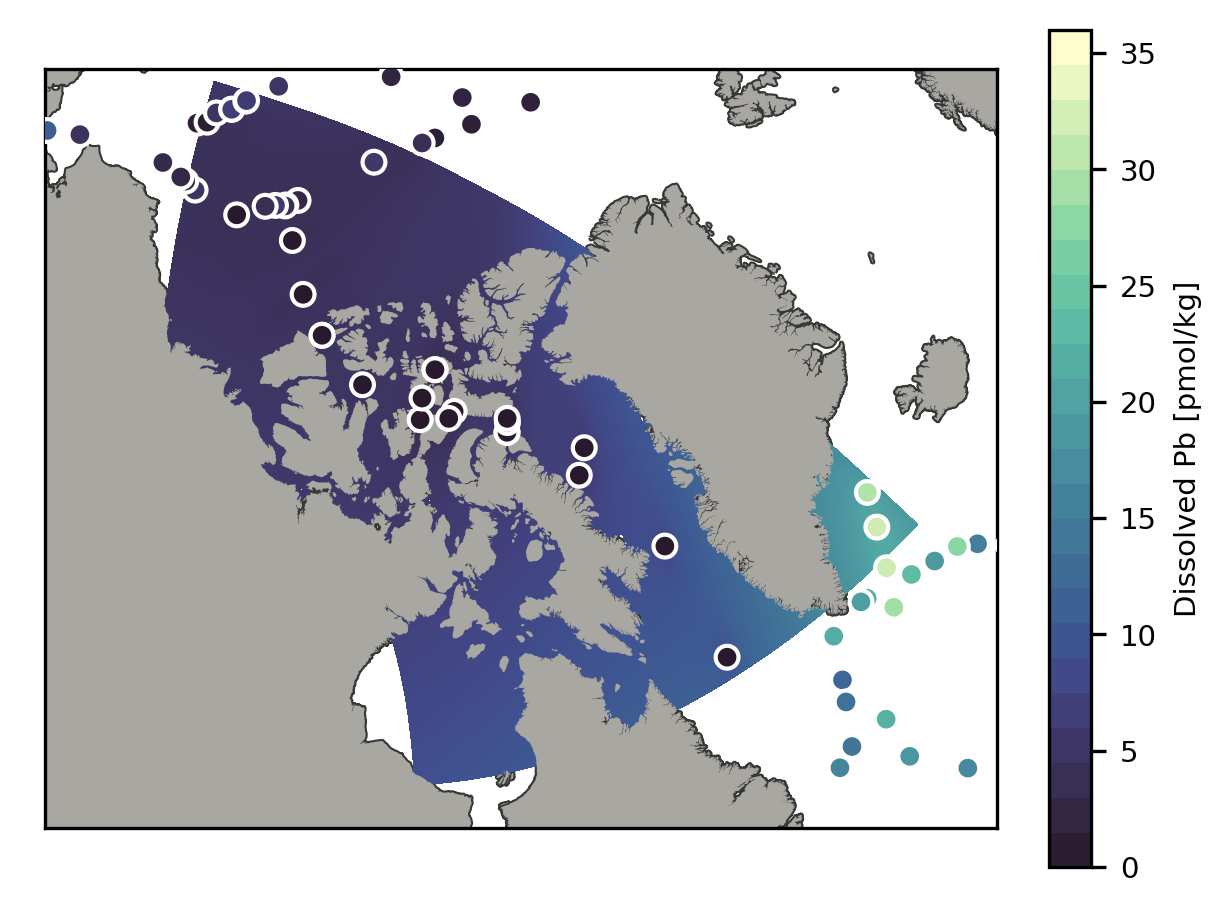

In [12]:
plot_krig(xx_yes, yy_yes, Z_yes, stns_yes, dpb_yes, 35)

Not using the CAA stations:

In [13]:
xx_no, yy_no, Z_no, stns_no, dpb_no = krig([0, 20])

In [104]:
def plot_forcing(forcing, z_level, vmax1=35):
    
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj(mesh_lon, mesh_lat)
    forcing_masked = np.ma.masked_where((mesh_bathy[z_level,:,:] < 0.1), forcing[z_level,:,:])
    proj.pcolormesh(x, y, forcing_masked, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r, zorder=2)

    # Colorbar:
    CS1 = proj.contourf(np.zeros((2,2)),np.zeros((2,2)), np.array([[0, vmax1],[0, vmax1]]), \
                        30, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r)
    CBar = plt.colorbar(CS1, fraction=0.04, ticks=np.arange(0, vmax1+5, 5))
    CBar.ax.tick_params(labelsize=7) 
    CBar.set_label('Dissolved Pb [pmol/kg]', fontsize=7)
    return

0.6391494274139404 30.63724446296692 11.287460621358615


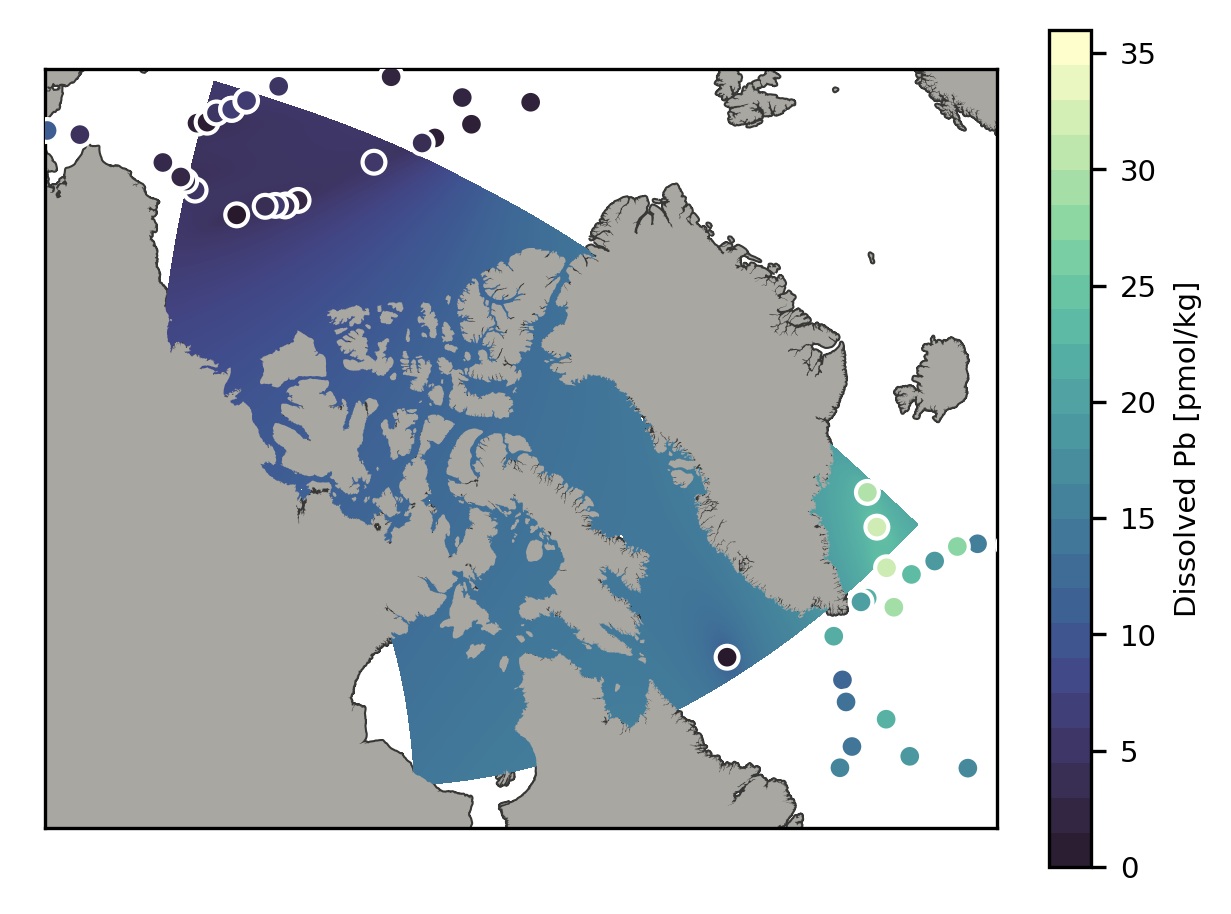

In [14]:
plot_krig(xx_no,yy_no,Z_no,stns_no,dpb_no, 35)

# Create the 3D initial conditions

Surface: 0 to 10 m

In [40]:
xx1, yy1, Z1, stns1, dpb1 = krig([0, 11])

0.026269190207472093 31.785764606084975 9.972244355035722


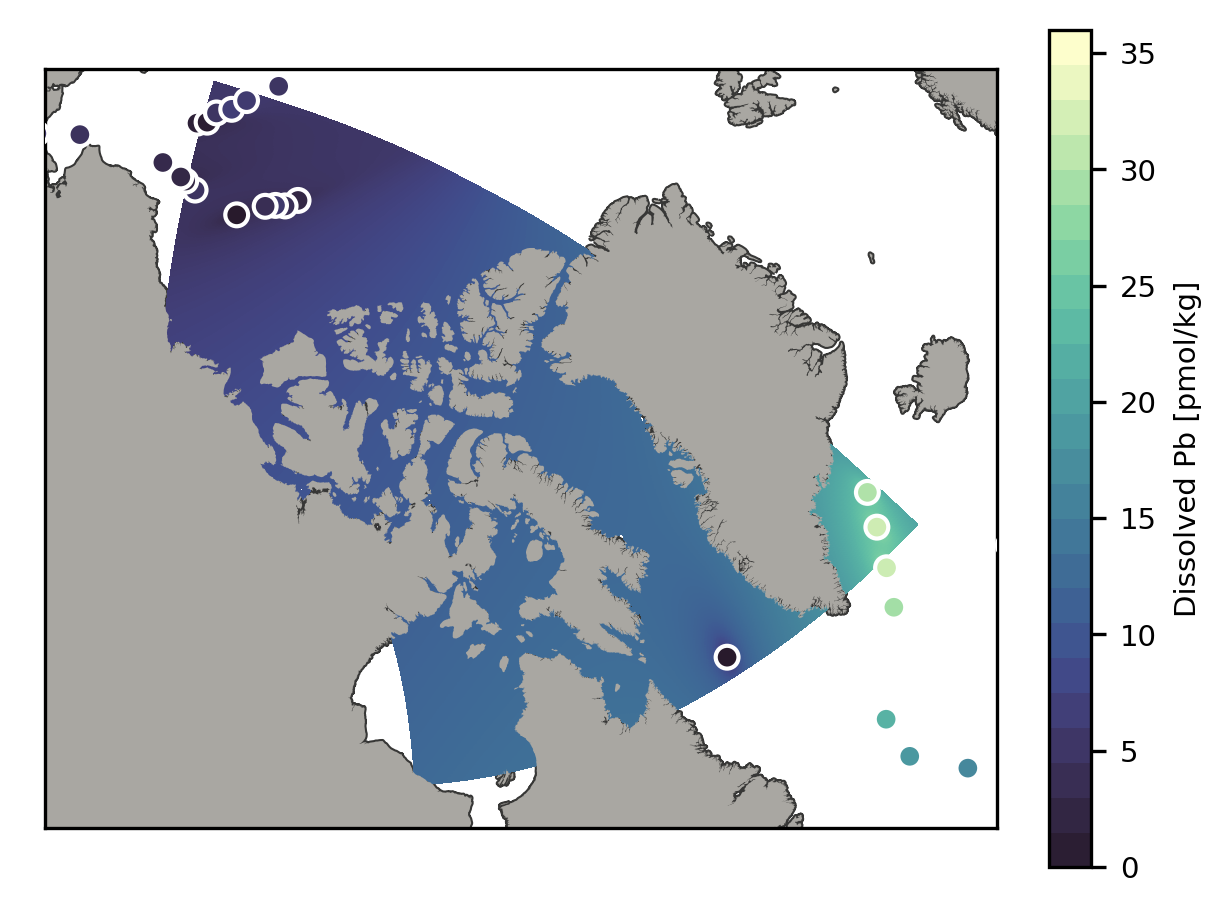

In [ ]:
plot_krig(xx1,yy1,Z1,stns1,dpb1, 35)

10-20 m:

In [42]:
xx11, yy11, Z11, stns11, dpb11 = krig([11, 22])

0.30081665702164173 18.9794104215689 1.101984230501406


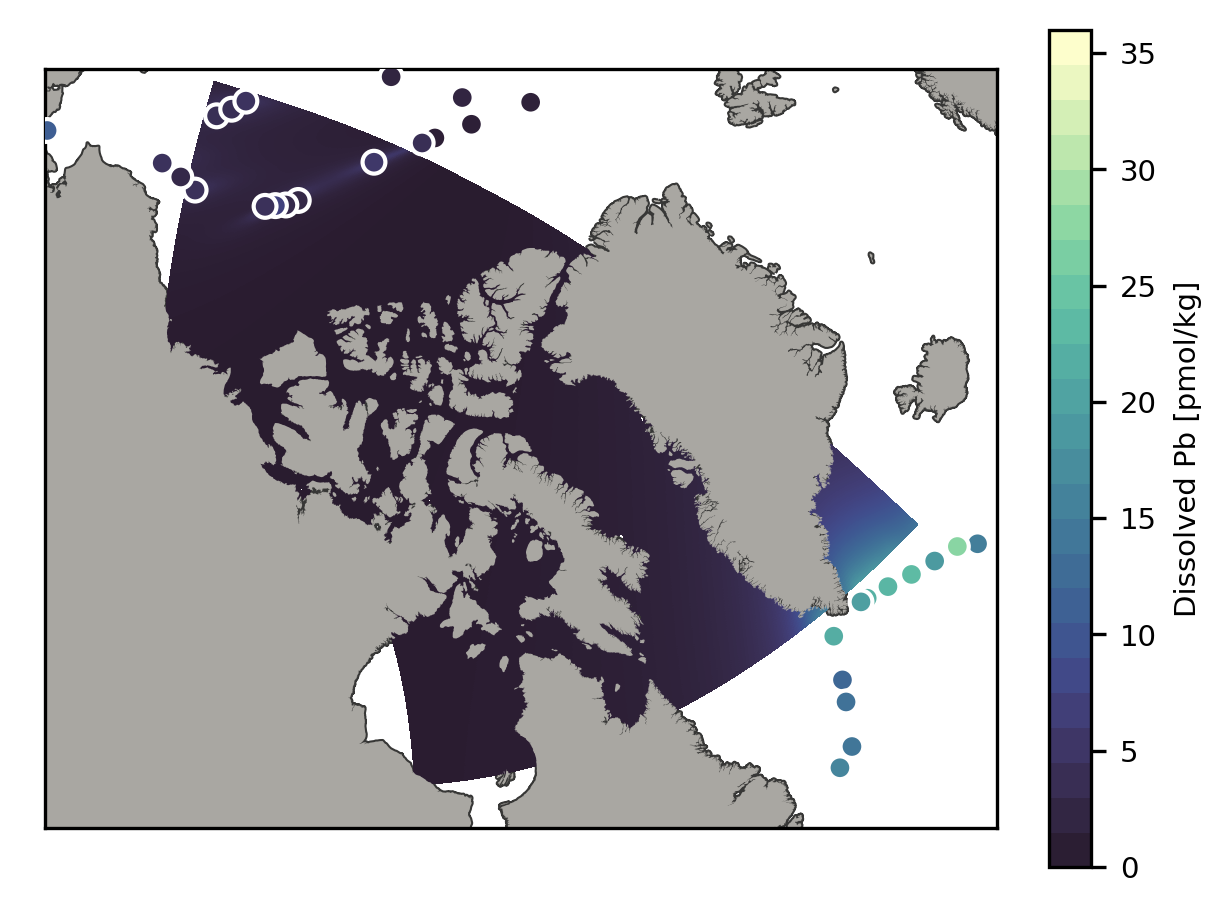

In [43]:
plot_krig(xx11,yy11,Z11,stns11,dpb11, 35)

20-50 m:

In [46]:
xx2, yy2, Z2, stns2, dpb2 = krig([22, 48])

0.0 30.95341233164072 1.115826322799306


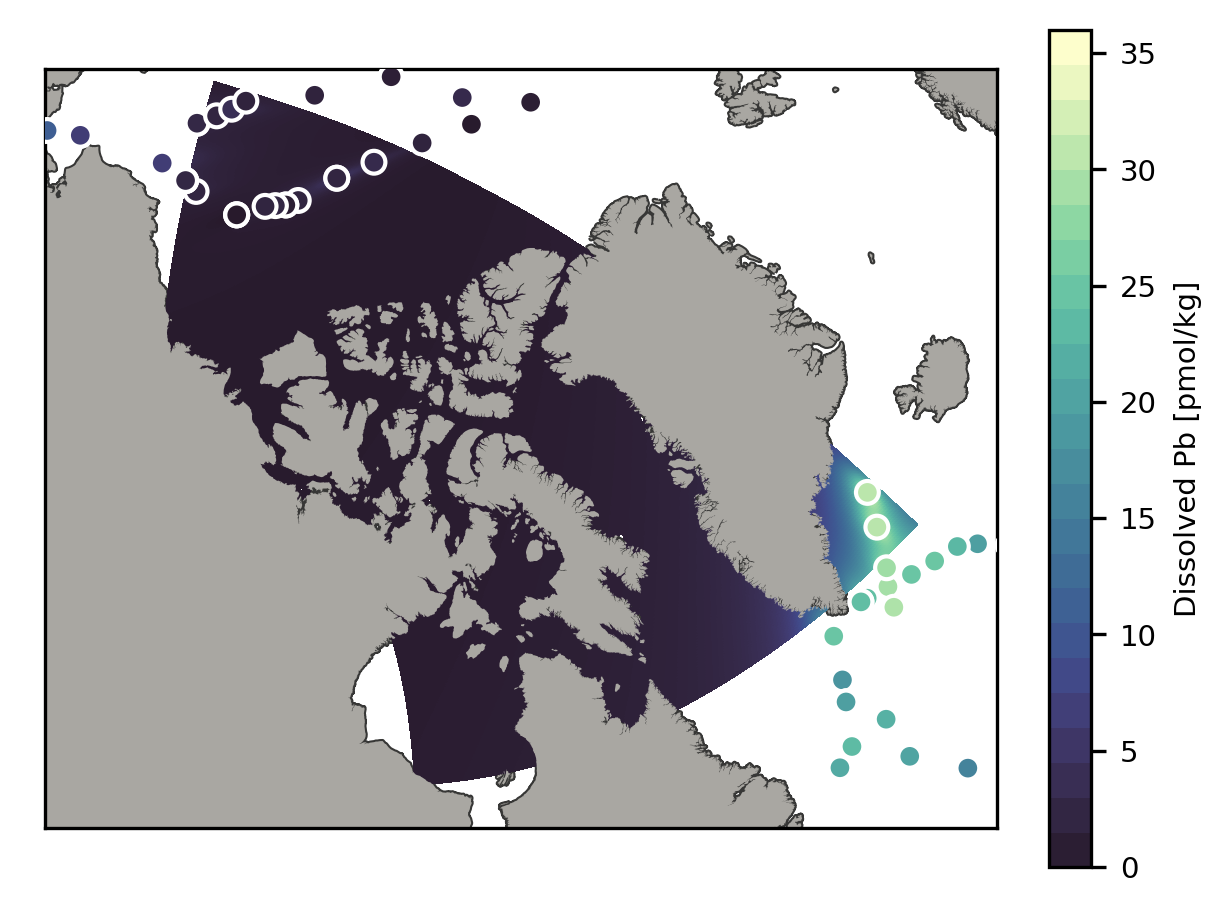

In [47]:
plot_krig(xx2,yy2,Z2,stns2,dpb2, 35)

50-100 m:

In [69]:
xx3, yy3, Z3, stns3, dpb3 = krig([48, 107])

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.002202749252319336 31.732471466064453 1.1838051276246242


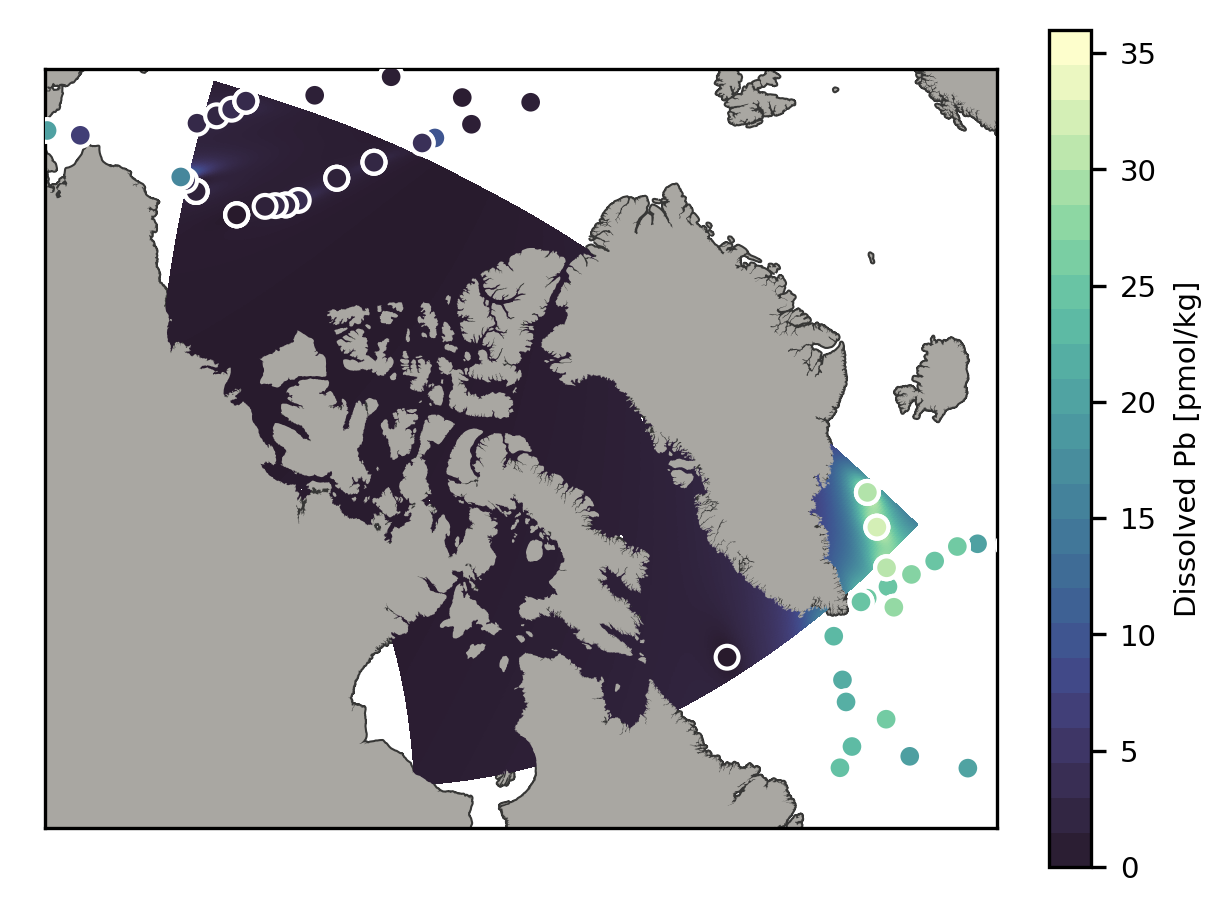

In [70]:
plot_krig(xx3,yy3,Z3,stns3,dpb3, 35)

100-400 m:

In [67]:
xx4, yy4, Z4, stns4, dpb4 = krig([107, 380])

0.0 32.65090662240982 1.1075917203855037


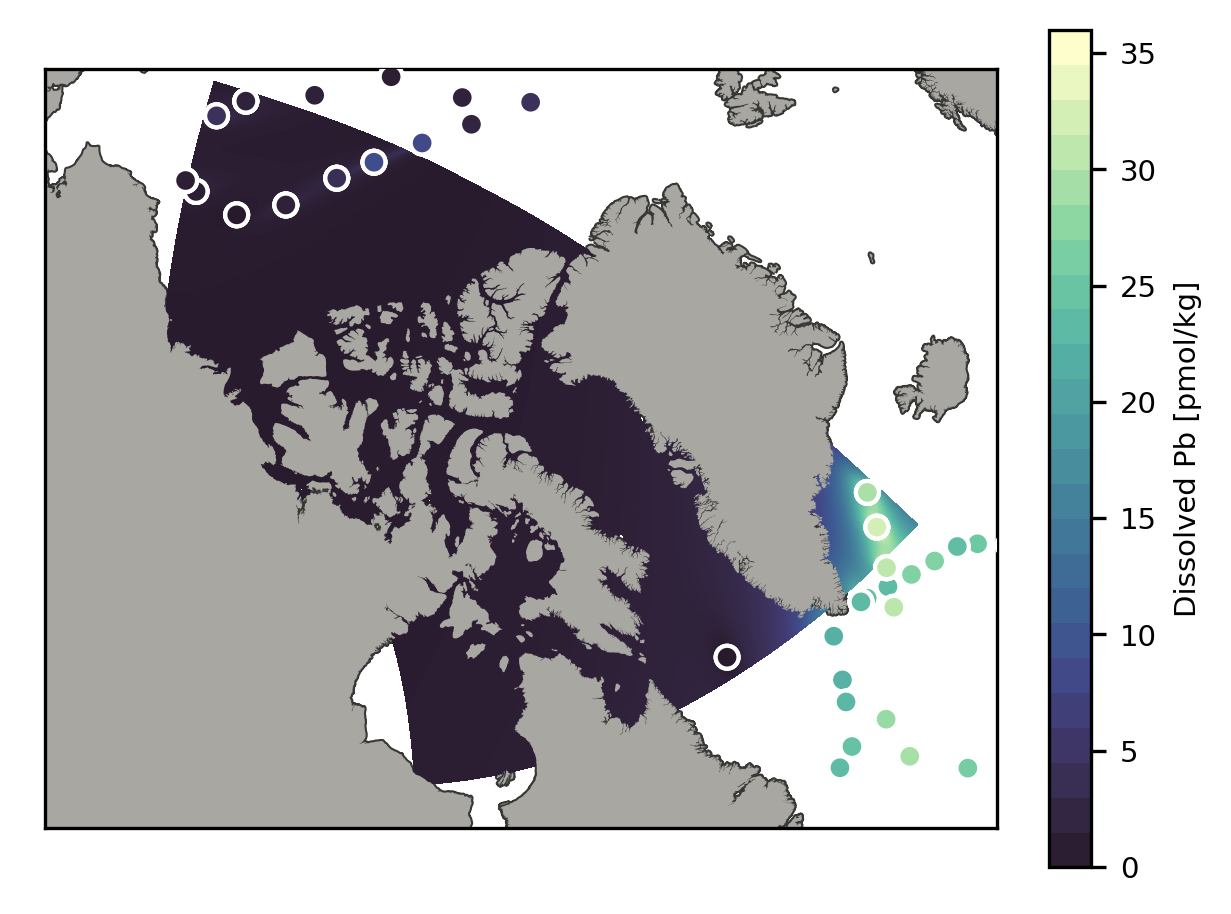

In [68]:
plot_krig(xx4,yy4,Z4,stns4,dpb4, 35)

400-800 m:

In [71]:
xx5, yy5, Z5, stns5, dpb5 = krig([380, 902])

0.0 42.885101318359375 1.2893771820263178


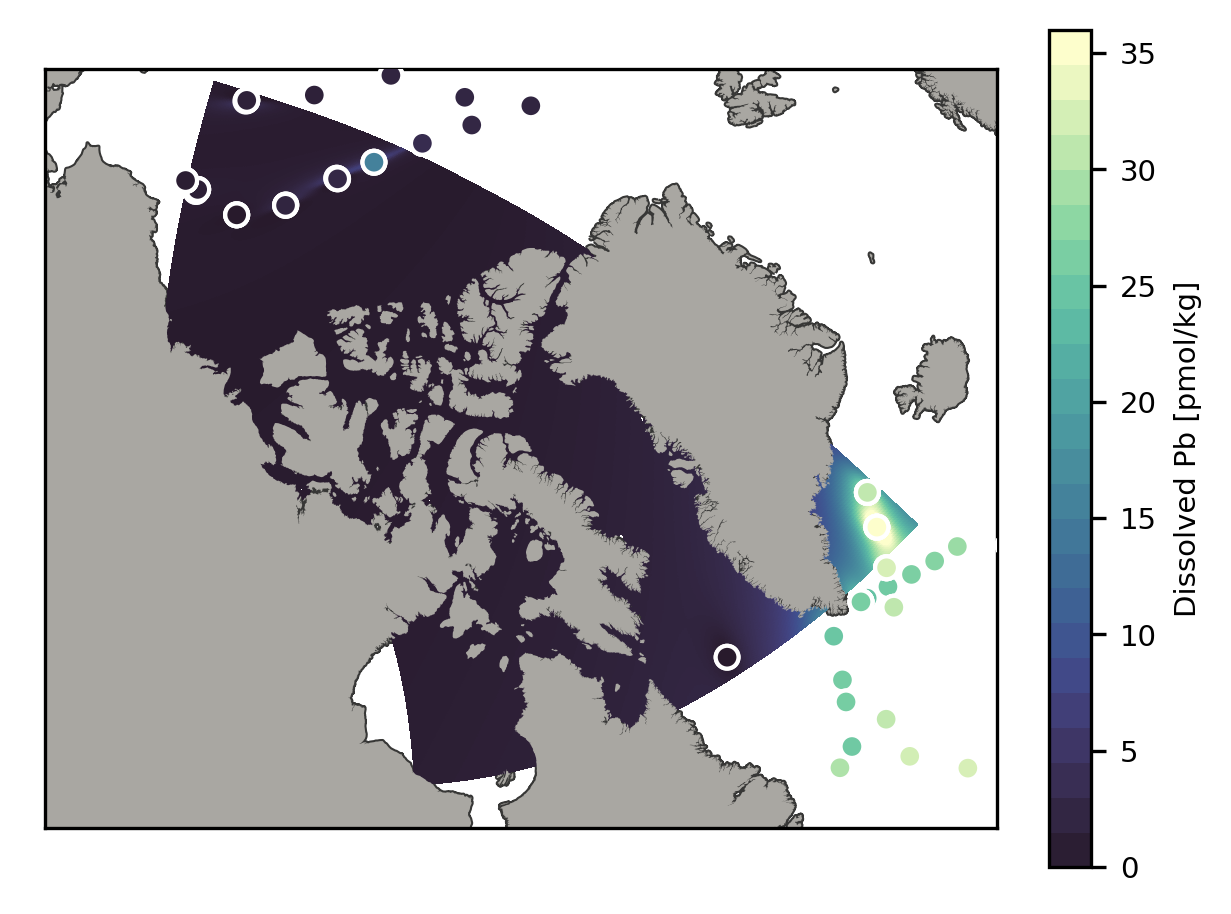

In [72]:
plot_krig(xx5,yy5,Z5,stns5,dpb5, 35)

900-1200 m:

In [81]:
xx6, yy6, Z6, stns6, dpb6 = krig([902, 1240])

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.0 76.46195602416992 9.822779257370497


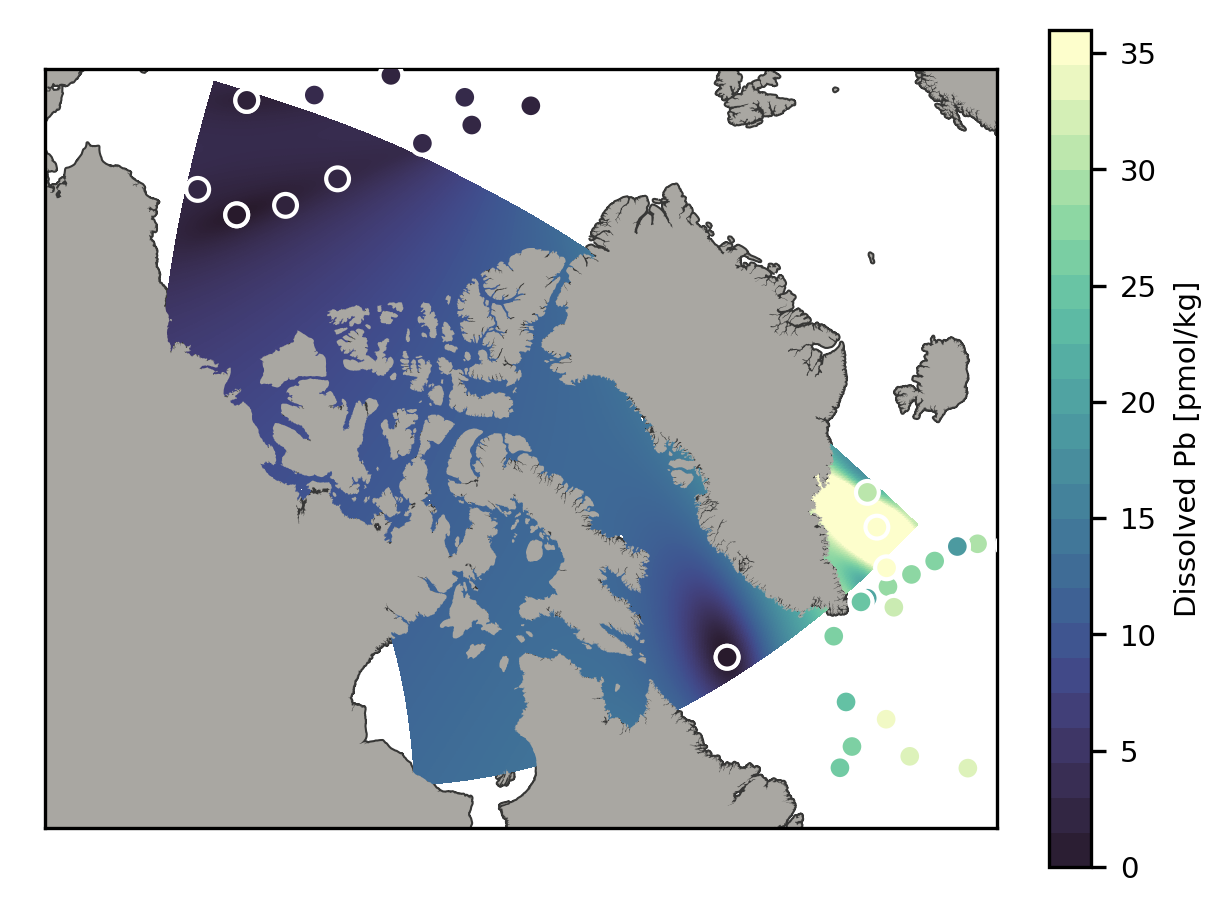

In [82]:
plot_krig(xx6,yy6,Z6,stns6,dpb6, 35)

1200-2000 m:

In [79]:
xx7, yy7, Z7, stns7, dpb7 = krig([1240, 1942])

0.0 33.13675308227539 1.235472752043717


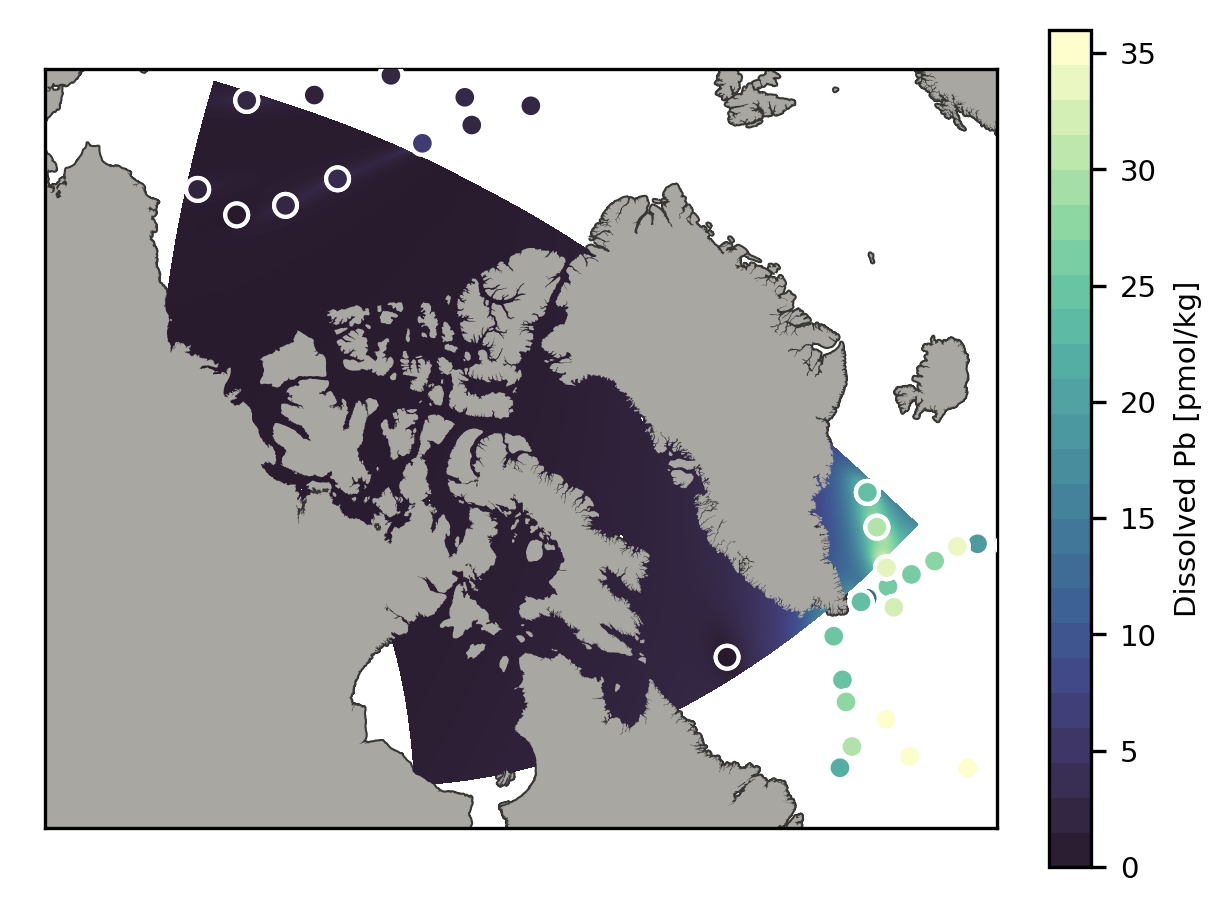

In [80]:
plot_krig(xx7,yy7,Z7,stns7,dpb7, 35)

2000-3000 m

In [83]:
xx8, yy8, Z8, stns8, dpb8 = krig([1942, 3221])

0.0 17.786023139953613 0.8485688393846345


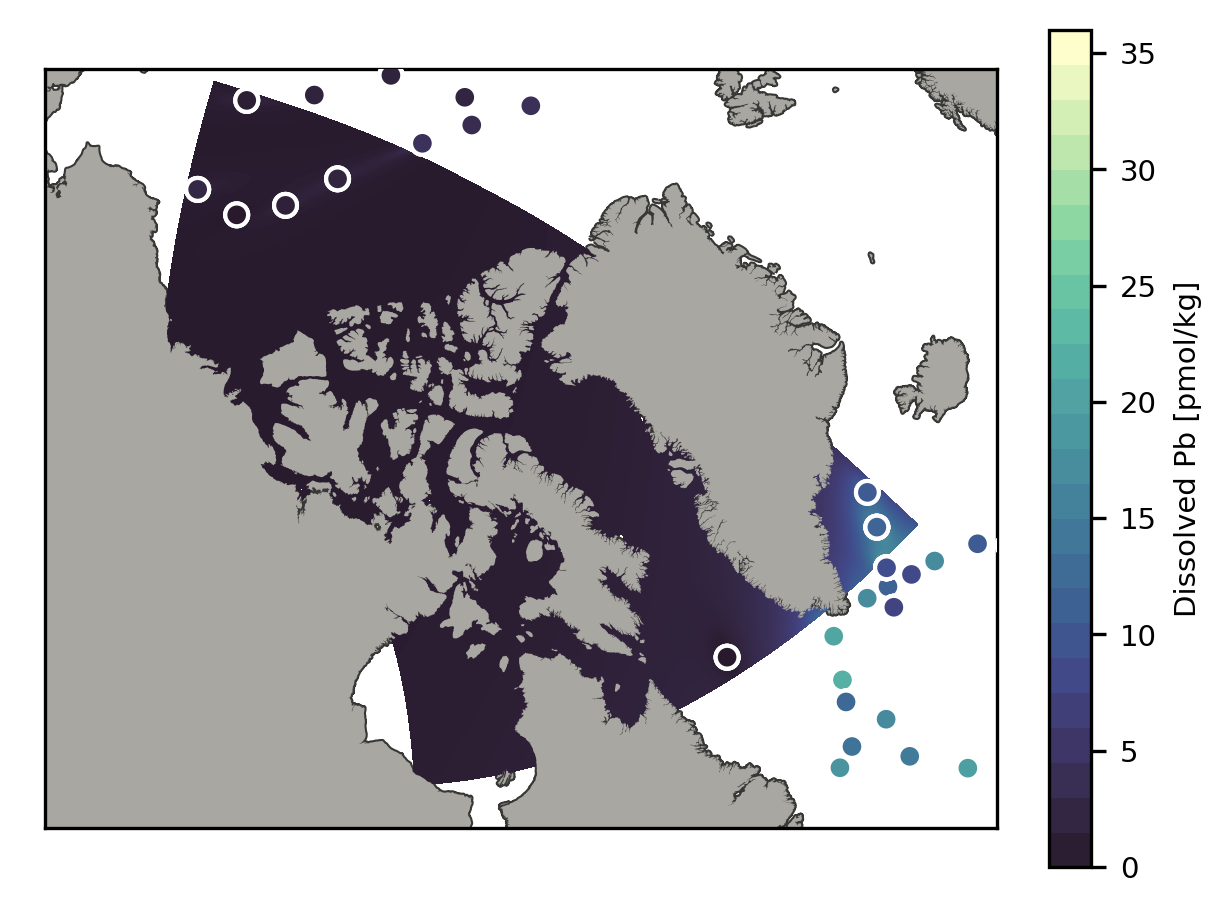

In [84]:
plot_krig(xx8,yy8,Z8,stns8,dpb8, 35)

Below 3000 m:

In [85]:
xx9, yy9, Z9, stns9, dpb9 = krig([3221, 5730])

1.3466644287109375 12.551986694335938 8.258624104725467


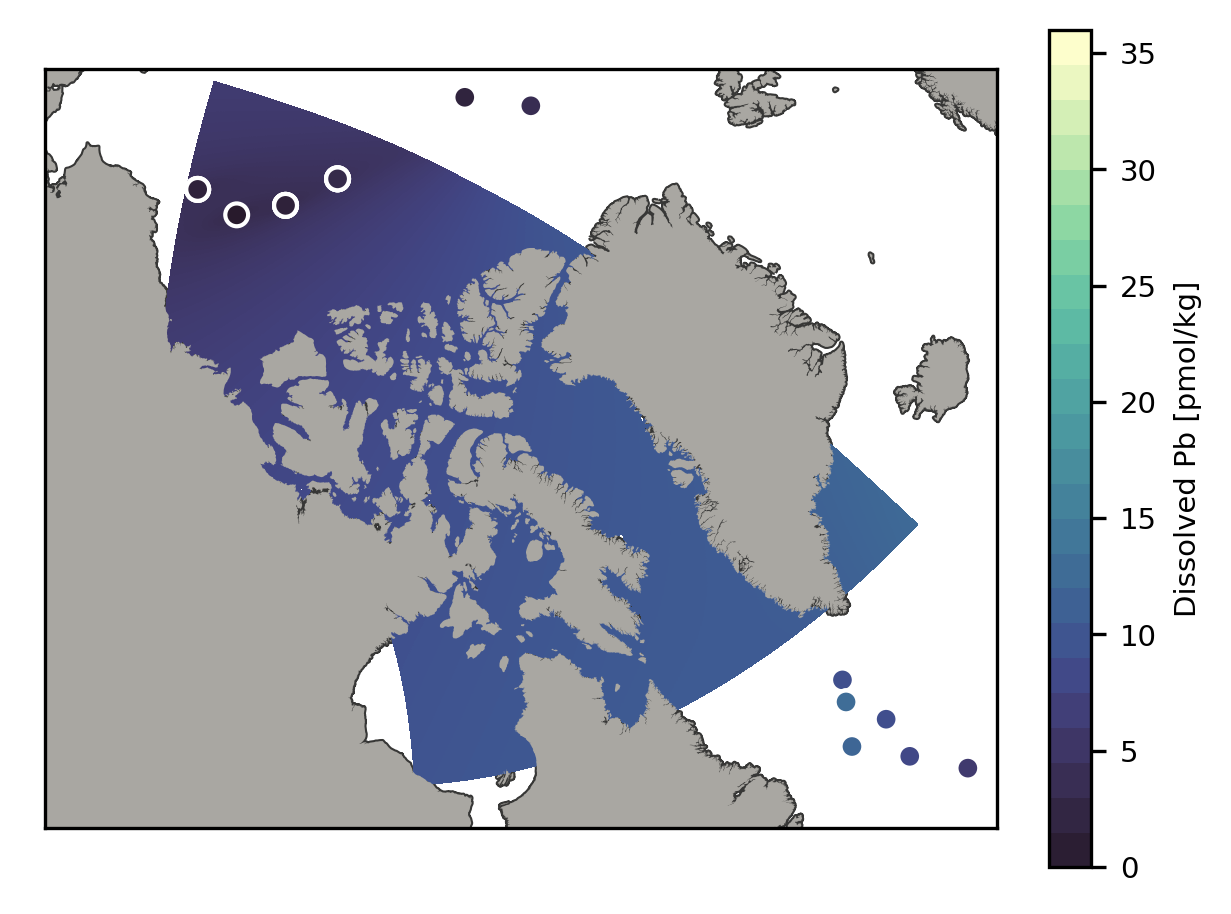

In [86]:
plot_krig(xx9,yy9,Z9,stns9,dpb9, 35)

Add these fields to the initial condition array:

| Variable | Depth range (m) | Model depth levels |
|----------|-----------------|--------------------|
| Z1       | 0-11            | 1-9                |
| Z11      | 11-22           | 9-13               |
| Z2       | 22-48           | 13-18              |
| Z3       | 48-107          | 18-23              |
| Z4       | 107-380         | 23-30              |
| Z5       | 380-902         | 30-35              |
| Z6       | 902-1240        | 35-37              |
| Z7       | 1240-1942       | 37-40              |
| Z8       | 1942-3221       | 40-44              |
| Z9       | 3221-5728       | 44-50              |

Surface concentrations estimated by Kriging:

In [87]:
ini_pb = np.empty((1,50,2400,1632))
ini_pb.fill(3)

In [90]:
# Surface concentrations estimated by Kriging:
ini_pb[0,0:9,imin:imax,jmin:jmax]   = Z1
ini_pb[0,9:13,imin:imax,jmin:jmax]  = Z11
ini_pb[0,13:18,imin:imax,jmin:jmax] = Z2
ini_pb[0,18:23,imin:imax,jmin:jmax] = Z3
ini_pb[0,23:30,imin:imax,jmin:jmax] = Z4
ini_pb[0,30:35,imin:imax,jmin:jmax] = Z5
ini_pb[0,35:37,imin:imax,jmin:jmax] = Z6
ini_pb[0,37:40,imin:imax,jmin:jmax] = Z7
ini_pb[0,40:44,imin:imax,jmin:jmax] = Z8
ini_pb[0,44:50,imin:imax,jmin:jmax] = Z9

In [91]:
ini_pb[ini_pb < 3] = 3

In [115]:
print(np.average(ini_pb[0,:,imin:imax,jmin:jmax]), np.amax(ini_pb[0,:,imin:imax,jmin:jmax]), np.amin(ini_pb[0,:,imin:imax,jmin:jmax]))

5.545743368183135 76.46195602416992 3.0


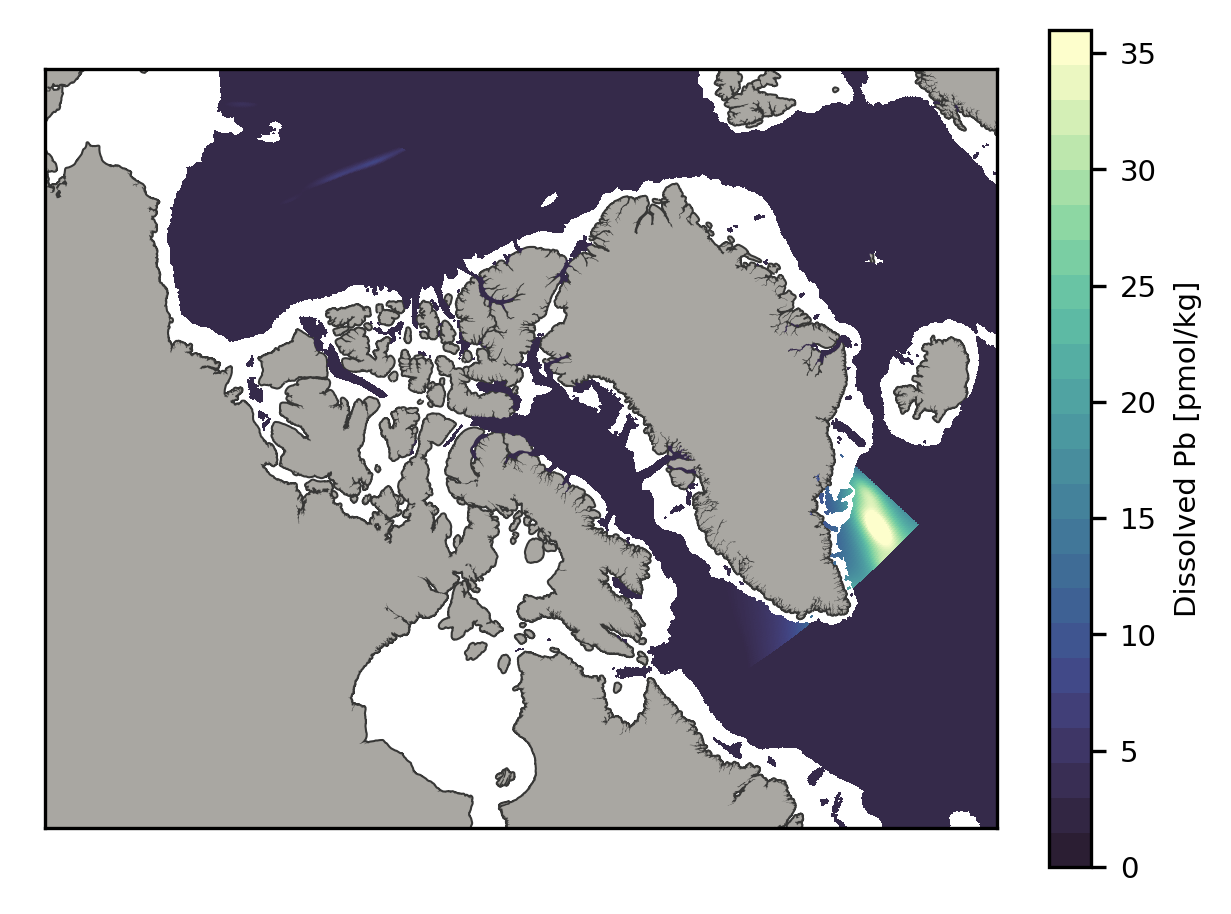

In [112]:
plot_forcing(ini_pb[0], 30)

### Write NetCDF file:

In [116]:
file_write = xr.Dataset(
    {'dPb': (("time_counter","deptht","y","x"), ini_pb*1e-12)}, 
    coords = {
        "time_counter": np.zeros(1),
        "deptht": np.zeros(50),
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        "long_name":'Dissolved Pb concentration IC',
        "units":"kmol/m3"
    },
)
file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/Pb_ini-20220330.nc', unlimited_dims='time_counter')